## Install deps

In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
%pip install category_encoders
%pip install catboost

You should consider upgrading via the 'c:\Users\aduny\Projects\ml\machine_learning\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\aduny\Projects\ml\machine_learning\Scripts\python.exe -m pip install --upgrade pip' command.


## Imports

In [2]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import numpy as np

## Load dataset

In [3]:
dataframe = read_csv("clear_all_data.csv", index_col=0)
dataframe.head()


,city,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district
0,Москва,1,5,1,12.00,291666,3500000,2012,19.0,9.1,Москва
1,Москва,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Москва
2,Москва,5,14,1,61.97,919799,57000000,2022,19.0,9.1,Москва
3,Москва,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Москва
4,Москва,12,17,1,47.60,324579,15450000,2019,19.0,10.0,Москва


## Define args and y

In [4]:
X = dataframe.drop("price_per_m2", axis=1)
y = dataframe.price_per_m2


## Split to train and test dataframes

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
from category_encoders import CatBoostEncoder

cat_features = ['district', "city"]
encoder = CatBoostEncoder()
X_train_encoded = X_train.copy()
X_train_encoded[cat_features] = encoder.fit_transform(X_train[cat_features], y_train)

In [7]:
X_test_encoded = X_test.copy()
X_test_encoded[cat_features] = encoder.transform(X_test[cat_features])

## Define and train models

In [8]:
model_list = []

In [9]:
param_grid = {
    "depth" : [5],
    "learning_rate": [0.375],
    "iterations": [1550]
}

### CatBoost

In [10]:
# catboost_regressor = CatBoostRegressor(task_type="GPU", devices="0:1", depth=8, iterations=2000, learning_rate=0.1)
catboost_regressor = CatBoostRegressor(od_type="Iter", od_wait=1000, depth=5, learning_rate=0.375, iterations=1550, loss_function="MAE")

In [11]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=catboost_regressor, param_grid=param_grid, cv=2, n_jobs=-1)

In [12]:
grid.fit(X_train_encoded, y_train)

0:	learn: 225197.5393750	total: 53.6ms	remaining: 1m 22s
1:	learn: 188960.7074775	total: 58.7ms	remaining: 45.5s
2:	learn: 167982.8469637	total: 62.6ms	remaining: 32.3s
3:	learn: 152176.7614329	total: 66.2ms	remaining: 25.6s
4:	learn: 136178.9633246	total: 69.7ms	remaining: 21.5s
5:	learn: 127226.8506233	total: 74.8ms	remaining: 19.2s
6:	learn: 117443.8985541	total: 78.7ms	remaining: 17.4s
7:	learn: 112872.7827013	total: 82.2ms	remaining: 15.9s
8:	learn: 110181.8660764	total: 85.6ms	remaining: 14.7s
9:	learn: 104354.3729793	total: 90.4ms	remaining: 13.9s
10:	learn: 101428.8196507	total: 94.2ms	remaining: 13.2s
11:	learn: 99867.4461600	total: 97.7ms	remaining: 12.5s
12:	learn: 96834.3736301	total: 101ms	remaining: 12s
13:	learn: 94425.9801862	total: 106ms	remaining: 11.6s
14:	learn: 90345.2868633	total: 110ms	remaining: 11.2s
15:	learn: 88422.5442240	total: 113ms	remaining: 10.9s
16:	learn: 86788.1359839	total: 117ms	remaining: 10.5s
17:	learn: 85840.3580876	total: 121ms	remaining: 10.3

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002D09CD4F4F0>,
             n_jobs=-1,
             param_grid={'depth': [5], 'iterations': [1550],
                         'learning_rate': [0.375]})

In [13]:
print(f"Best estimator: {grid.best_estimator_}")
print(f"Best score: {grid.best_score_}")
print(f"Best params: {grid.best_params_}")

Best estimator: <catboost.core.CatBoostRegressor object at 0x000002D0BD5F6EF0>
Best score: -0.469152867599908
Best params: {'depth': 5, 'iterations': 1550, 'learning_rate': 0.375}


In [14]:
model_list.append(grid)

## Make prediction

In [15]:
predict_list = []

for model in model_list:
    predict_list.append(model.predict(X_test_encoded))

## Plot of data

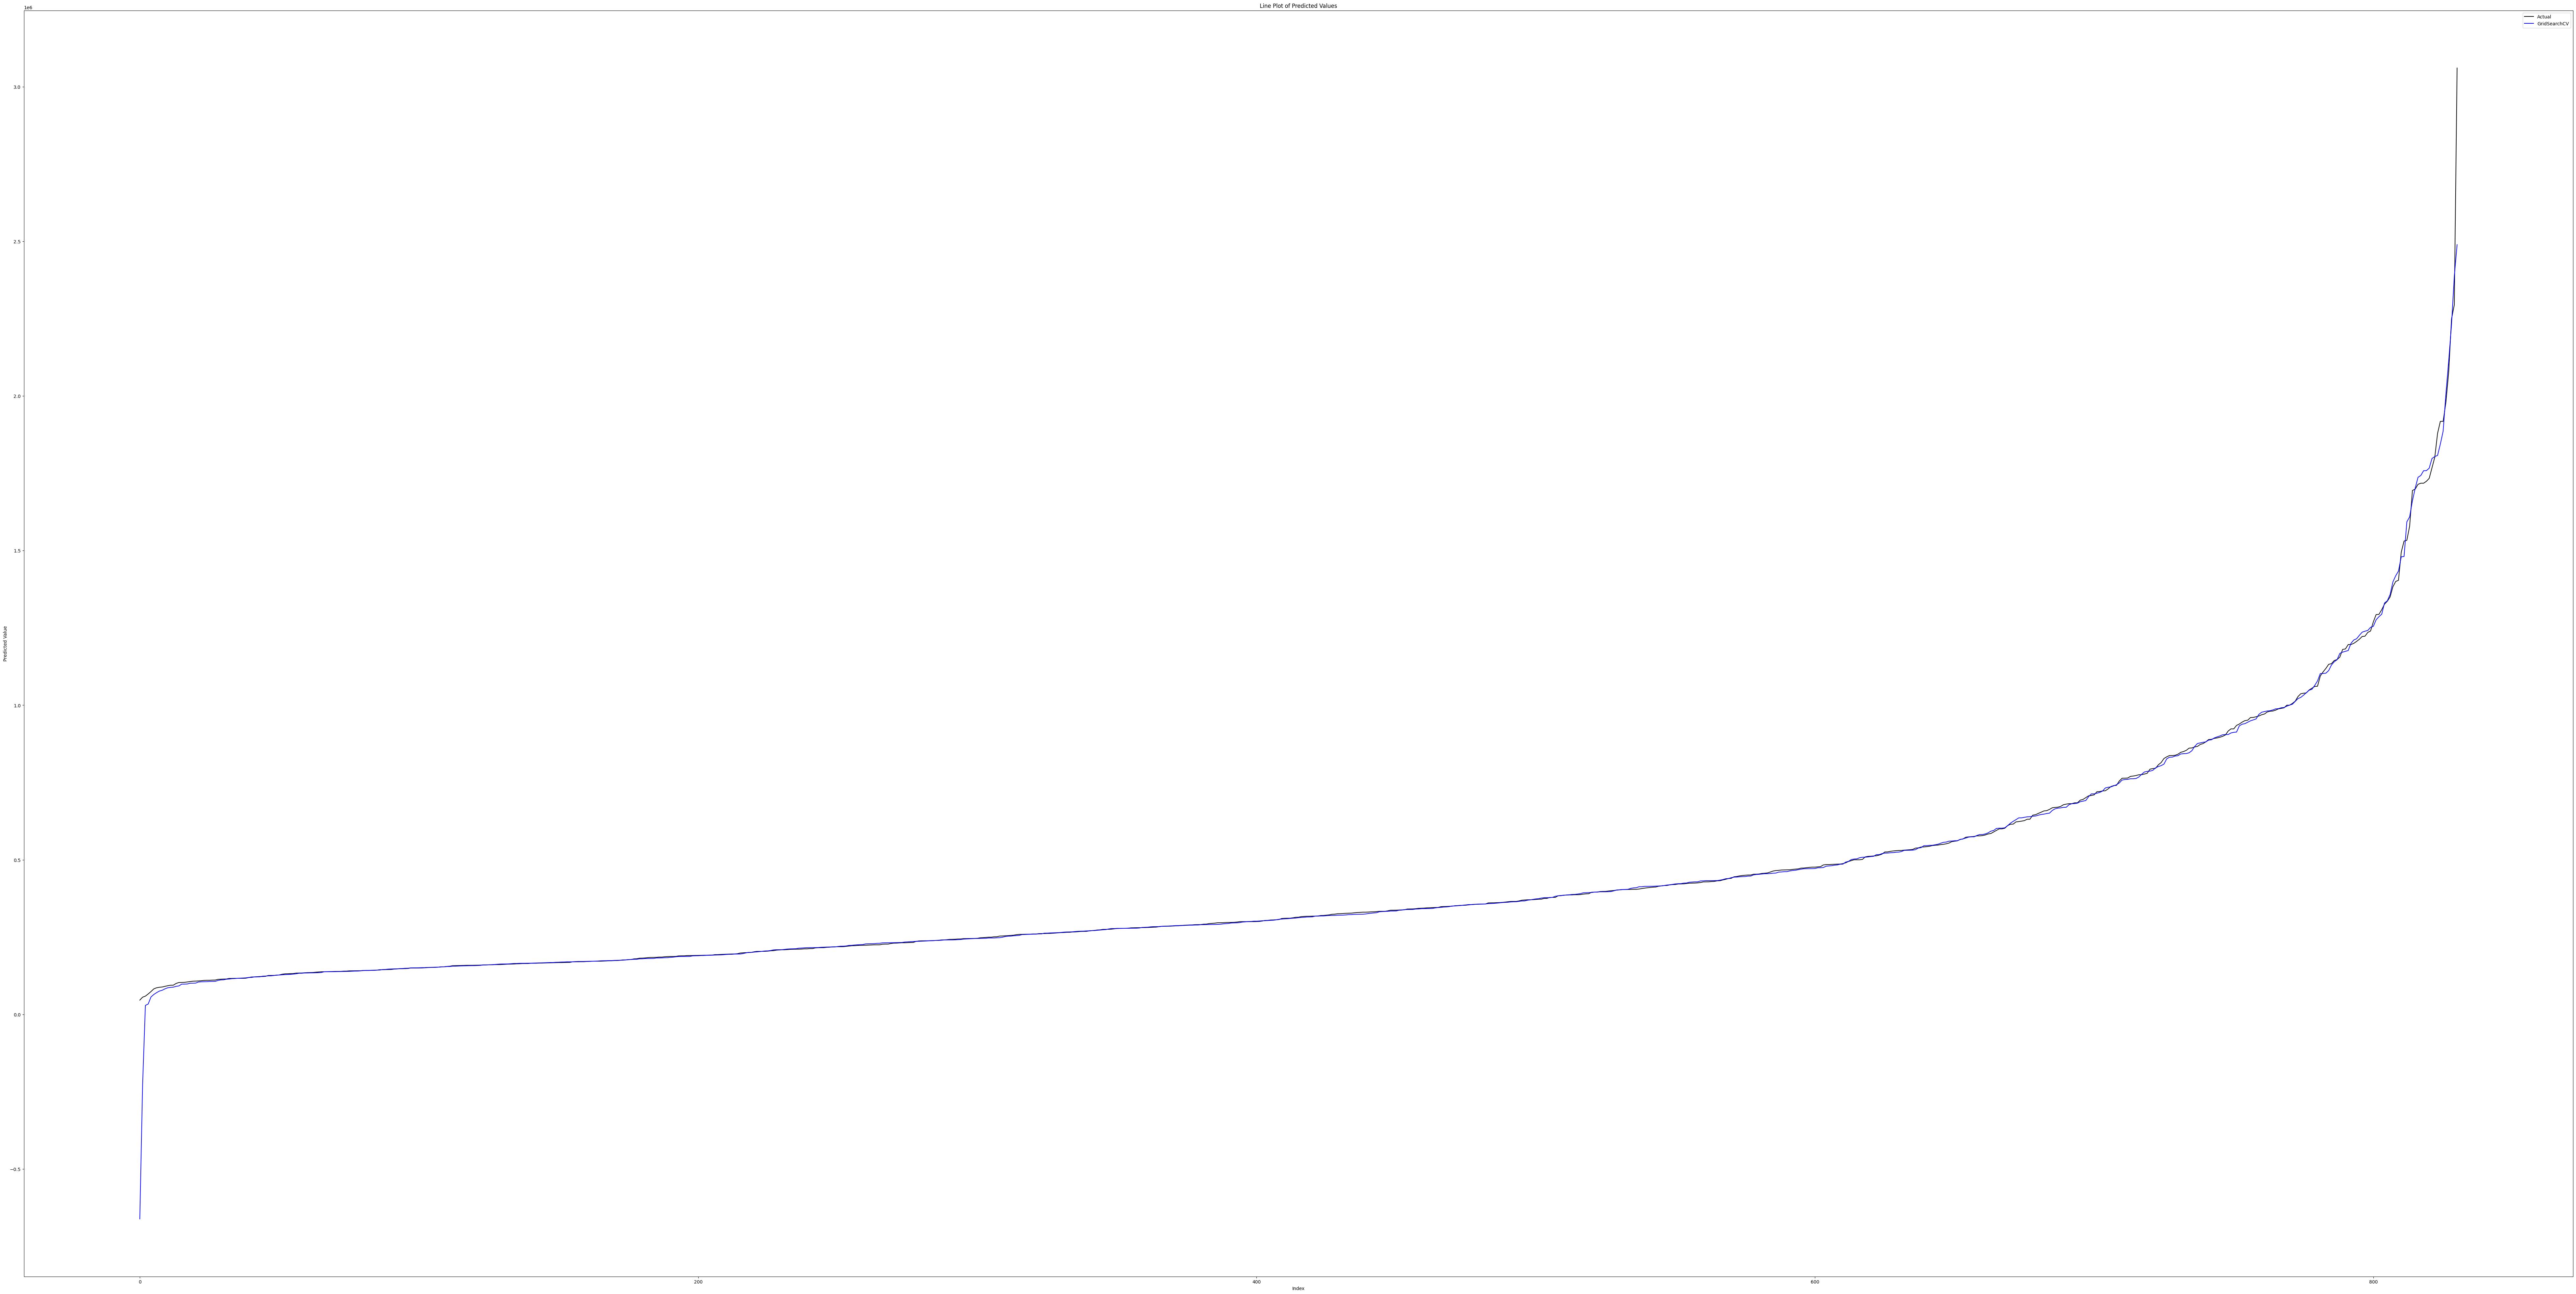

In [16]:
from matplotlib import pyplot as plt
from matplotlib import colors
import pandas as pd
import seaborn as sns
import numpy as np

ALL_COLORS = ["blue","orange","purple","green","white","gray"]

plt.figure(figsize=(100, 50))
sns.lineplot(x=range(len(y_test)), y=y_test.sort_values(), color='black', label='Actual')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.title('Line Plot of Predicted Values')

for i in range(0, len(model_list)):
    y = np.sort(predict_list[i])
    sns.lineplot(x=range(len(predict_list[i])), y=y, color=ALL_COLORS[i], label=type(model_list[i]).__name__)

plt.show()

## Check score of model

In [17]:
print("Scores: ")
for i, model in enumerate(model_list):
    print(f"\n* {type(model_list[i]).__name__}: {model.score(X_test_encoded, y_test)*100:.2f}%\t")

Scores: 

* GridSearchCV: 98.72%	


## Mean errors

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Absolute

In [19]:
print("MAE (Mean Absolute Error): ")
for i, predict in enumerate(predict_list):
    mse = mean_absolute_error(y_true=y_test, y_pred=predict)
    print(f"\n* {type(model_list[i]).__name__}: {mse:.2f}\t")

MAE (Mean Absolute Error): 

* GridSearchCV: 12745.01	


### Squared

In [20]:
print("MSE (Mean Squared Error): ")
for i, predict in enumerate(predict_list):
    print(f"\n* {type(model_list[i]).__name__}: {mean_squared_error(y_test, predict):.2f}\t")


MSE (Mean Squared Error): 

* GridSearchCV: 1666795569.21	
